In [1]:
! pip install --user tokenizers

In [2]:
# Note that you will need to restart the kernel
# before your will be able to use this module after
# the above installation is completed.

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import tokenizers
import io

In [3]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [5]:
import urllib
data = []
my_url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"
with urllib.request.urlopen(my_url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

In [6]:
data.shape

In [7]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
#n_seq = 1000
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification

In [8]:
data.shape

In [9]:
eng = np.array([x[0] for x in data])
por = np.array([x[1] for x in data])

In [10]:
eng.shape

In [11]:
eng[0:5]

array(['Get these people out of here.', 'I had completely forgotten.',
       'It makes no difference to me whether he comes or not.',
       'This is all I can do for you.', "I don't sleep in a bed."],
      dtype='<U184')

In [12]:
por.shape

In [13]:
unknown_token = "<UNK>"  # token for unknown words
special_tokens = [unknown_token, "<START>","<STOP>"]  # special tokens

eng_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token=unknown_token))
eng_token_trainer = tokenizers.trainers.BpeTrainer(vocab_size=100000,special_tokens=special_tokens)
eng_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

por_tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(unk_token=unknown_token))
por_token_trainer = tokenizers.trainers.BpeTrainer(vocab_size=100000,special_tokens=special_tokens)
por_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

In [14]:
with open("eng_strings.txt","w") as f:
    for s in eng:
        f.write(s)
        f.write("\n")
with open("por_strings.txt","w") as f:
    for s in por:
        f.write(s)
        f.write("\n")

In [15]:
eng_tokenizer.train(["eng_strings.txt"],eng_token_trainer)
por_tokenizer.train(["por_strings.txt"],por_token_trainer)

In [16]:
eng_tokenizer.save("eng_trained.json")
por_tokenizer.save("por_trained.json")

In [17]:
eng_tokenizer.encode("Here is a test.").tokens

['Here', 'is', 'a', 'test', '.']

In [18]:
temp = eng_tokenizer.encode("Here is a test.").ids
temp

In [19]:
temp = eng_tokenizer.decode(temp + [0,0])
temp

'Here is a test .'

In [20]:
eng_tokenizer.get_vocab_size()

In [21]:
por_tokenizer.get_vocab_size()

In [22]:
eng_recoded = np.array([eng_tokenizer.decode(eng_tokenizer.encode(s).ids) for s in eng])
por_recoded = np.array([por_tokenizer.decode(por_tokenizer.encode(s).ids) for s in por])

In [23]:
eng_recoded[0]

'Get these people out of here .'

In [24]:
eng[0]

'Get these people out of here.'

In [25]:
por_recoded[0]

'Tire essas pessoas daqui .'

In [26]:
por[0]

'Tire essas pessoas daqui.'

In [27]:
def encode_seq(x,tokenizer,max_length=0):
    # String to integer
    x = tokenizer.encode("<START>"+x+"<STOP>").ids
    x += [0]*(max_length-len(x))
    return x

def decode_seq(x,tokenizer):
    return tokenizer.decode(x)

In [28]:
temp = encode_seq(eng_recoded[0],eng_tokenizer,20)
temp

In [29]:
len(temp)

In [30]:
decode_seq(temp,eng_tokenizer)

'Get these people out of here .'

In [31]:
temp = encode_seq(por_recoded[0],por_tokenizer,20)
temp

In [32]:
decode_seq(temp,por_tokenizer)

'Tire essas pessoas daqui .'

In [33]:
max_eng = np.max([len(encode_seq(i,eng_tokenizer)) for i in eng_recoded])
max_eng

41

In [34]:
max_por = np.max([len(encode_seq(i,por_tokenizer)) for i in por_recoded])
max_por

38

In [35]:
X = np.vstack([encode_seq(x,eng_tokenizer,max_eng) for x in eng_recoded])
Y = np.vstack([encode_seq(x,por_tokenizer,max_por) for x in por_recoded])

In [36]:
enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train

array([[   1, 1200,  892, ...,    0,    0,    0],
       [   1,   34,  277, ...,    0,    0,    0],
       [   1,  192, 1112, ...,    0,    0,    0],
       ...,
       [   1,   99,  749, ...,    0,    0,    0],
       [   1,  244, 3130, ...,    0,    0,    0],
       [   1,  139, 3623, ...,    0,    0,    0]])

In [37]:
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[   1, 3332, 1669, ...,    0,    0,    0],
       [   1,  735, 1661, ...,    0,    0,    0],
       [   1,  190,  187, ...,    0,    0,    0],
       ...,
       [   1,  128,  762, ...,    0,    0,    0],
       [   1,  540, 3931, ...,    0,    0,    0],
       [   1,   41, 4998, ...,    0,    0,    0]])

In [38]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[3332, 1669,  525, ...,    0,    0,    0],
       [ 735, 1661, 1886, ...,    0,    0,    0],
       [ 190,  187, 2441, ...,    0,    0,    0],
       ...,
       [ 128,  762, 1077, ...,    0,    0,    0],
       [ 540, 3931,   97, ...,    0,    0,    0],
       [  41, 4998,  170, ...,    0,    0,    0]])

In [39]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

(136243, 41)
(136243, 37)
(136243, 37)


In [40]:
print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(34061, 41)
(34061, 37)
(34061, 37)


# Encoder-Decoder Network

In [41]:
class RecurrentResidual(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 bidirectional = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
        self.rnn_layer = torch.nn.LSTM(latent_size,
                                       latent_size // 2 if bidirectional else latent_size,
                                       bidirectional=bidirectional,
                                       batch_first=True)
    def forward(self, x):
        return x + self.rnn_layer(self.layer_norm(x))[0]

### Encoder Component

In [42]:
class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size,True) for _ in range(n_layers)
        ])

    def forward(self, x):
        y = x
        y = self.embedding(y)
        y = self.dropout(y)
        y = self.rnn_layers(y)[:,-1]
        return y                                    

In [43]:
enc_x_train[0:5].shape

In [44]:
enc_net = EncoderNetwork(num_tokens=eng_tokenizer.get_vocab_size())

summary(enc_net,input_data=torch.Tensor(enc_x_train[0:5]).long())

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 64]                   --
├─Embedding: 1-1                         [5, 41, 64]               1,257,280
├─Dropout1d: 1-2                         [5, 41, 64]               --
├─Sequential: 1-3                        [5, 41, 64]               --
│    └─RecurrentResidual: 2-1            [5, 41, 64]               --
│    │    └─LayerNorm: 3-1               [5, 41, 64]               128
│    │    └─LSTM: 3-2                    [5, 41, 64]               25,088
│    └─RecurrentResidual: 2-2            [5, 41, 64]               --
│    │    └─LayerNorm: 3-3               [5, 41, 64]               128
│    │    └─LSTM: 3-4                    [5, 41, 64]               25,088
│    └─RecurrentResidual: 2-3            [5, 41, 64]               --
│    │    └─LayerNorm: 3-5               [5, 41, 64]               128
│    │    └─LSTM: 3-6                    [5, 41, 64]               

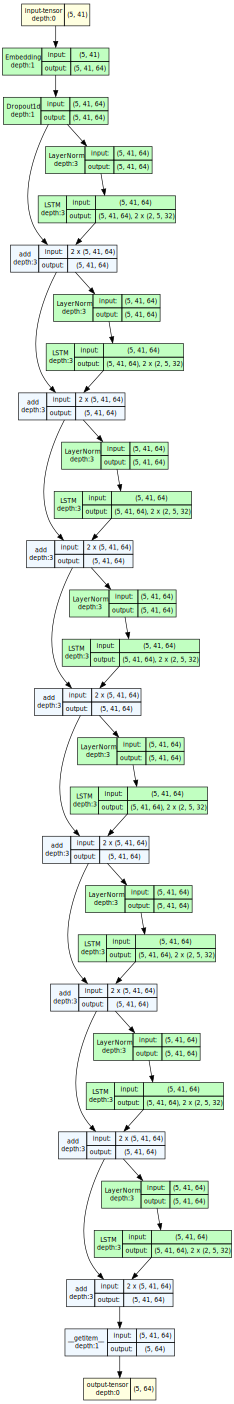

In [45]:
model_graph = draw_graph(enc_net, input_data=torch.Tensor(enc_x_train[0:5]).long(), device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3, dtypes=[torch.long])
model_graph.visual_graph

### Decoder Component

In [46]:
class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        # self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = torch.nn.Linear(latent_size*2,
                                      latent_size)
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size,False) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)

    def forward(self, x_enc, x_dec):
        y_enc = x_enc.unsqueeze(1).repeat(1,x_dec.shape[1],1)
        y_dec = self.embedding(x_dec)
        # y_dec = self.dropout(y_dec)
        y = y_enc
        y = torch.concatenate([y_enc,y_dec],-1)
        y = self.linear(y)
        y = self.rnn_layers(y)
        y = self.output_layer(y)
        return y                                    

In [47]:
enc_x_train[0:5].shape

In [48]:
dec_x_train[0:5].shape

In [49]:
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device))

tensor([[-0.8766, -0.1424,  0.8814, -0.2617, -0.5049, -0.5079, -1.7486, -0.2253,
          1.4870, -0.0881,  0.7911, -1.7145, -0.8664, -0.9008,  0.3751, -0.6218,
          0.1032,  0.1121,  0.5259,  0.3466,  0.3471, -0.6736,  0.0072,  0.2901,
          1.4486, -1.1141,  0.2541,  0.0471,  1.8655,  0.6842,  0.1768,  0.0932,
          0.6301, -0.4769,  0.3541,  0.2075, -0.0326,  0.7939,  0.4819,  0.6766,
         -0.2158,  0.7911, -0.3806,  0.2666, -0.1059, -0.0039,  0.4292, -0.7824,
         -0.0815, -0.1263, -0.2377, -0.4843, -0.2408,  0.2002,  0.3004, -0.5009,
          0.9402, -0.0871,  0.0500, -0.5097, -0.4596, -0.0643, -0.0103,  0.3272],
        [-0.8767, -0.1426,  0.8807, -0.2623, -0.5052, -0.5078, -1.7484, -0.2250,
          1.4872, -0.0882,  0.7912, -1.7165, -0.8668, -0.9003,  0.3749, -0.6216,
          0.1033,  0.1120,  0.5257,  0.3467,  0.3480, -0.6738,  0.0080,  0.2907,
          1.4487, -1.1136,  0.2539,  0.0471,  1.8653,  0.6842,  0.1771,  0.0928,
          0.6301, -0.4769, 

In [50]:
dec_net = DecoderNetwork(num_tokens=por_tokenizer.get_vocab_size())

summary(dec_net,input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(),
                            torch.Tensor(dec_x_train[0:5]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 37, 32286]            --
├─Embedding: 1-1                         [5, 37, 64]               2,066,304
├─Linear: 1-2                            [5, 37, 64]               8,256
├─Sequential: 1-3                        [5, 37, 64]               --
│    └─RecurrentResidual: 2-1            [5, 37, 64]               --
│    │    └─LayerNorm: 3-1               [5, 37, 64]               128
│    │    └─LSTM: 3-2                    [5, 37, 64]               33,280
│    └─RecurrentResidual: 2-2            [5, 37, 64]               --
│    │    └─LayerNorm: 3-3               [5, 37, 64]               128
│    │    └─LSTM: 3-4                    [5, 37, 64]               33,280
│    └─RecurrentResidual: 2-3            [5, 37, 64]               --
│    │    └─LayerNorm: 3-5               [5, 37, 64]               128
│    │    └─LSTM: 3-6                    [5, 37, 64]            

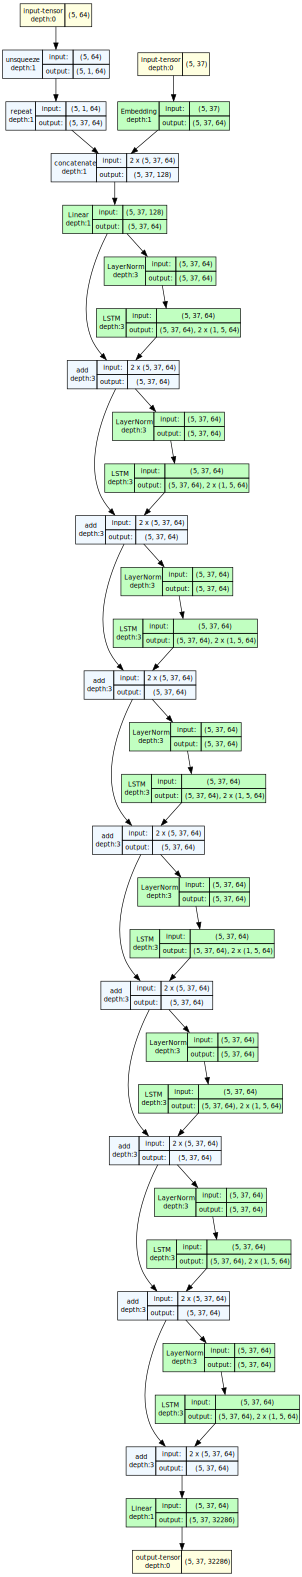

In [51]:
model_graph = draw_graph(dec_net, input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(),
                            torch.Tensor(dec_x_train[0:5]).long()], device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3, dtypes=[torch.long])
model_graph.visual_graph

### Training Hooks

In [52]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


### Encoder-Decoder Network

In [53]:
class EncDecNetwork(EncDecLightningModule):
    def __init__(self,
                 num_enc_tokens,
                 num_dec_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens,
                         **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens,latent_size,n_layers)
        self.dec_net = DecoderNetwork(num_dec_tokens,latent_size,n_layers)

    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)

In [55]:
enc_dec_net = EncDecNetwork(num_enc_tokens=eng_tokenizer.get_vocab_size(),
                            num_dec_tokens=por_tokenizer.get_vocab_size(),
                            latent_size=256,
                            n_layers=4)
summary(enc_dec_net,input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                torch.Tensor(dec_x_train[0:1]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
EncDecNetwork                            [1, 37, 32286]            --
├─EncoderNetwork: 1-1                    [1, 256]                  --
│    └─Embedding: 2-1                    [1, 41, 256]              5,029,120
│    └─Dropout1d: 2-2                    [1, 41, 256]              --
│    └─Sequential: 2-3                   [1, 41, 256]              --
│    │    └─RecurrentResidual: 3-1       [1, 41, 256]              395,776
│    │    └─RecurrentResidual: 3-2       [1, 41, 256]              395,776
│    │    └─RecurrentResidual: 3-3       [1, 41, 256]              395,776
│    │    └─RecurrentResidual: 3-4       [1, 41, 256]              395,776
├─DecoderNetwork: 1-2                    [1, 37, 32286]            --
│    └─Embedding: 2-4                    [1, 37, 256]              8,265,216
│    └─Linear: 2-5                       [1, 37, 256]              131,328
│    └─Sequential: 2-6                   [1, 3

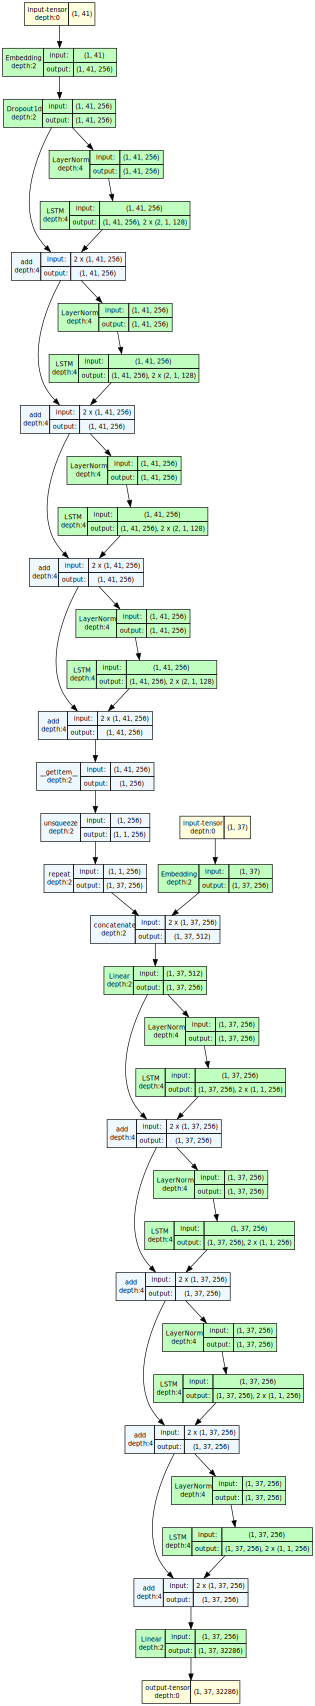

In [56]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()],
                         device=device,
                         hide_inner_tensors=True,hide_module_functions=True,
                         expand_nested=False, depth=4, dtypes=[torch.long])
model_graph.visual_graph

### Training Time

In [57]:
batch_size = 128
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())),
                                       shuffle=True, batch_size=batch_size,
                                       num_workers=8)
xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(),
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())),
                                     shuffle=False, batch_size=batch_size,
                                     num_workers=8)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [58]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-Tokenization",
                              version="full-data-3")

In [59]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=True,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
trainer.validate(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │  1.4317351087811403e-05   │
│         val_loss          │    10.340932846069336     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 1.4317351087811403e-05, 'val_loss': 10.340932846069336}]

In [61]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │  1.7820915672928095e-05   │
│         test_loss         │    10.481877326965332     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 1.7820915672928095e-05, 'test_loss': 10.481877326965332}]

In [ ]:
trainer.fit(enc_dec_net, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 6.6 M 
3 | dec_net  | DecoderNetwork     | 18.8 M
------------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.655   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [64]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,test_acc,test_loss,train_acc,train_loss
0,0.001160,7.254284,0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,0,0,0.0,7.287779,NaN,NaN
2,0.235678,4.870842,0,7,NaN,NaN,NaN,NaN
3,NaN,NaN,0,7,NaN,NaN,0.201624,6.060038
4,0.379903,4.203480,1,15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
75,NaN,NaN,36,295,NaN,NaN,0.588796,1.923134
76,0.486412,3.857674,37,303,NaN,NaN,NaN,NaN
77,NaN,NaN,37,303,NaN,NaN,0.596359,1.902793
78,0.474687,3.862310,38,311,NaN,NaN,NaN,NaN


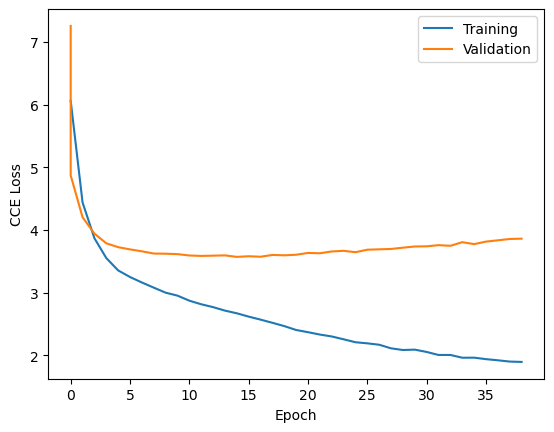

In [65]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

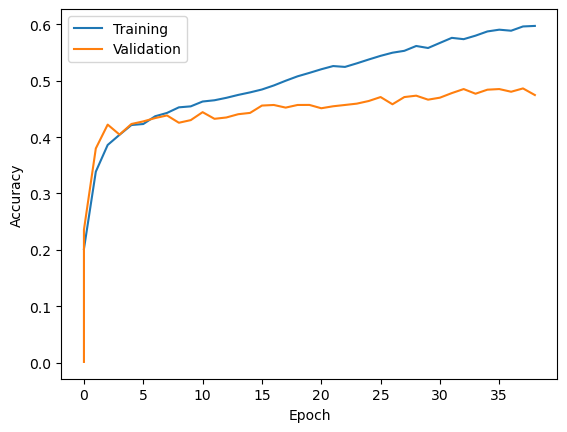

In [66]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Direct Validation of Results

### Teacher Forcing

In [67]:
# What should we see?
i = 0
print('Input:', enc_x_val[i])
print('Output:', dec_y_val[i])

Input: [  1  92 125   3   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
Output: [233   6   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [69]:
print('Input:', decode_seq(enc_x_val[i],eng_tokenizer))
print('Output:', decode_seq(dec_y_val[i],por_tokenizer))

Input: Get out !
Output: Sai .


In [70]:
result = enc_dec_net(torch.Tensor(enc_x_val[i:i+1]).long(),
                     torch.Tensor(dec_x_val[i:i+1]).long()).cpu().detach().numpy()
result.argmax(-1)[0]

array([74,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [71]:
# Only if the above fails due to device management reasons...
# result = enc_dec_net(torch.Tensor(enc_x_val[i:i+1]).long().to(device),
#                      torch.Tensor(dec_x_val[i:i+1]).long().to(device)).cpu().detach().numpy()
# result.argmax(-1)[0]

In [72]:
decode_seq(result.argmax(-1)[0],por_tokenizer)

'Eu .'

In [73]:
trainer.validate(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.4746868908405304     │
│         val_loss          │    3.8623108863830566     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.4746868908405304, 'val_loss': 3.8623108863830566}]

### Non-Teacher Forcing

In [74]:
# Get the gestalt context for the input sequence(s)
context = enc_dec_net.enc_net(torch.Tensor(enc_x_val[i:i+1]).long())

# Prep a starting token...
token = torch.zeros((1,dec_y_val.shape[1])).long()
token[0,0] = 1
token

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

In [75]:
# What do we get with just one pass?
result = enc_dec_net.dec_net(context,token)
result.cpu().detach().numpy().argmax(-1)[0]

array([74,  5,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [76]:
decode_seq(result.cpu().detach().numpy().argmax(-1)[0],por_tokenizer)

'Eu - .'

In [77]:
token[0,1] = result[0,0].argmax(-1)
token

tensor([[ 1, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [78]:
# Feed next token in...
result = enc_dec_net.dec_net(context,token)
result.cpu().detach().numpy().argmax(-1)[0]

array([ 74, 105,   6,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2])

In [79]:
decode_seq(result.cpu().detach().numpy().argmax(-1)[0],por_tokenizer)

'Eu sou .'

### Complete Sequence with Non-Teacher Forcing

In [80]:
# Complete max_length cycles with the decoder
context = enc_dec_net.enc_net(torch.Tensor(enc_x_val[i:i+1]).long())
token = torch.zeros((1,dec_y_val.shape[1])).long()
token[0,0] = 1

for x in range(dec_y_val.shape[1]-1):
    result = enc_dec_net.dec_net(context,token).argmax(-1)
    if result[0,x] == 2:
        break
    token[0,x+1] = result[0,x]
result = enc_dec_net.dec_net(context,token).argmax(-1).cpu().detach().numpy()[0]
result

array([ 74, 105, 782,   6,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2])

In [82]:
decode_seq(result,por_tokenizer)

'Eu sou tímido .'

In [83]:
result.shape

In [84]:
dec_y_val.shape

Accuracy **without** teacher forcing...

In [85]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19919508695602417    │
│         test_loss         │     7.28166389465332      │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.19919508695602417, 'test_loss': 7.28166389465332}]